In [1]:
# import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import joblib
import os

from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

In [8]:
# Reading and consultation

df = pd.read_csv(r'./SEER Breast Cancer Dataset .csv', encoding='ascii')
df.head(2)

,Age,Race,Marital Status,Unnamed: 3,T Stage,N Stage,6th Stage,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,43,"Other (American Indian/AK Native, Asian/Pacifi...",Married (including common law),NaN,T2,N3,IIIC,Moderately differentiated; Grade II,Regional,40,Positive,Positive,19,11,1,Alive
1,47,"Other (American Indian/AK Native, Asian/Pacifi...",Married (including common law),NaN,T2,N2,IIIA,Moderately differentiated; Grade II,Regional,45,Positive,Positive,25,9,2,Alive


In [3]:
# Drop unvalide column 'Unnamed'
df = df.drop(columns=['Unnamed: 3'])
df.columns


Index(['Age', 'Race ', 'Marital Status', 'T Stage ', 'N Stage', '6th Stage',
       'Grade', 'A Stage', 'Tumor Size', 'Estrogen Status',
       'Progesterone Status', 'Regional Node Examined',
       'Reginol Node Positive', 'Survival Months', 'Status'],
      dtype='object')

In [4]:
# Nombre de caractéristiques (colonnes) et d'échantillons (lignes)
num_features = df.shape[1]
num_samples = df.shape[0]
print("\nNombre de caractéristiques (colonnes) :", num_features)
print("Nombre d'échantillons (lignes) :", num_samples)


Nombre de caractéristiques (colonnes) : 15
Nombre d'échantillons (lignes) : 4024


In [5]:
# Distribution des statuts (Alive vs Dead)
status_distribution = df['Status'].value_counts()
print("\nDistribution des statuts :")
print(status_distribution)


Distribution des statuts :
Status
Alive    3408
Dead      616
Name: count, dtype: int64


In [6]:
# Spliting the Data into training Set qnd test set
# Conserving data 
dfs = df
# Get The target Status ( "Dead or Alive")
Y = df['Status'] 

# Choosing features/inputs
dfs = dfs.drop(columns=['Status'])
X = dfs[dfs.columns]

# Train_Set and Test_Set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Inputs :  \n", X_train.columns)
print("Target :  \n", y_train)


Inputs :  
 Index(['Age', 'Race ', 'Marital Status', 'T Stage ', 'N Stage', '6th Stage',
       'Grade', 'A Stage', 'Tumor Size', 'Estrogen Status',
       'Progesterone Status', 'Regional Node Examined',
       'Reginol Node Positive', 'Survival Months'],
      dtype='object')
Target :  
 2665    Alive
3740    Alive
2138    Alive
1419     Dead
283      Dead
        ...  
1130    Alive
1294    Alive
860      Dead
3507    Alive
3174    Alive
Name: Status, Length: 3219, dtype: object


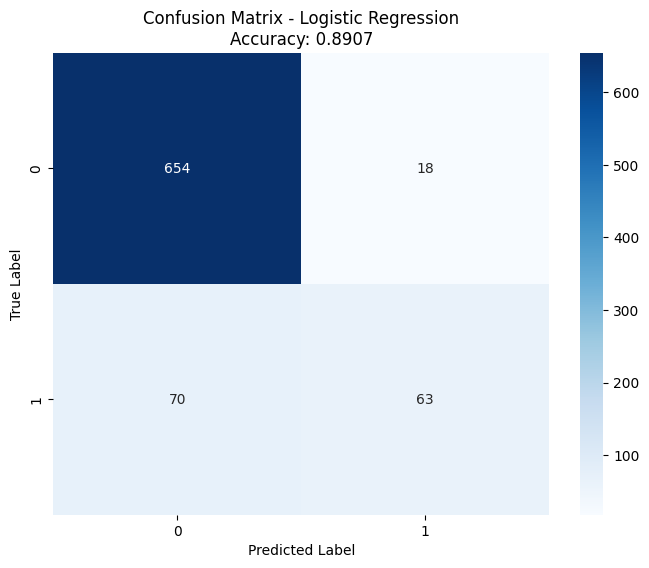


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

       Alive       0.90      0.97      0.94       672
        Dead       0.78      0.47      0.59       133

    accuracy                           0.89       805
   macro avg       0.84      0.72      0.76       805
weighted avg       0.88      0.89      0.88       805



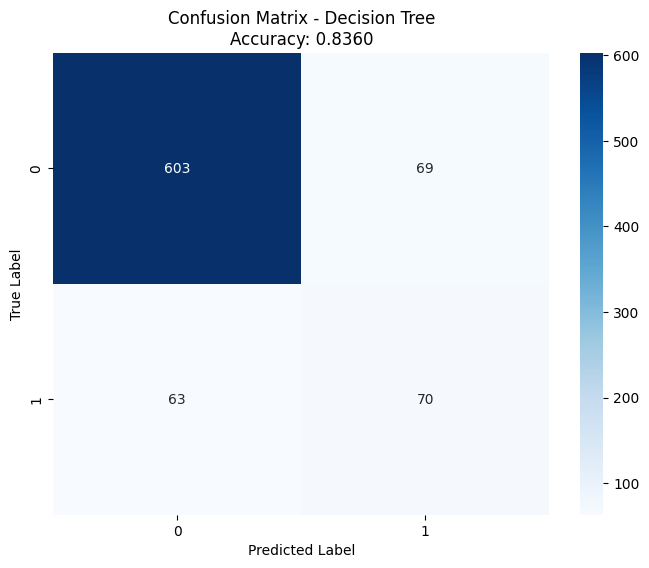


Classification Report for Decision Tree:
              precision    recall  f1-score   support

       Alive       0.91      0.90      0.90       672
        Dead       0.50      0.53      0.51       133

    accuracy                           0.84       805
   macro avg       0.70      0.71      0.71       805
weighted avg       0.84      0.84      0.84       805



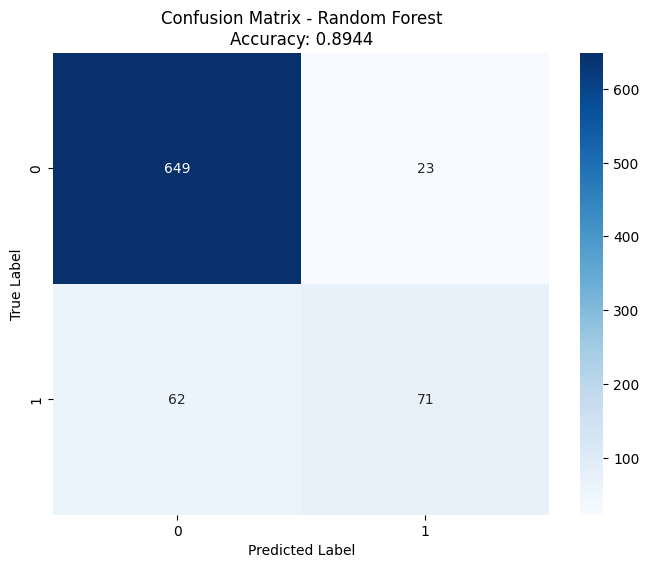


Classification Report for Random Forest:
              precision    recall  f1-score   support

       Alive       0.91      0.97      0.94       672
        Dead       0.76      0.53      0.63       133

    accuracy                           0.89       805
   macro avg       0.83      0.75      0.78       805
weighted avg       0.89      0.89      0.89       805



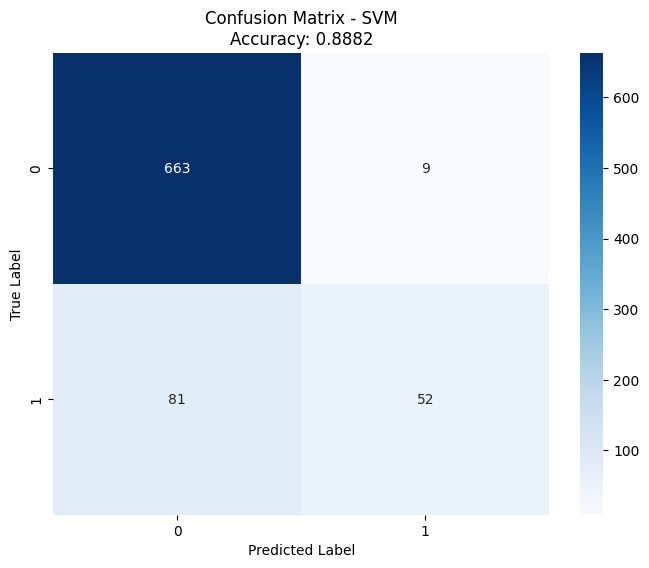


Classification Report for SVM:
              precision    recall  f1-score   support

       Alive       0.89      0.99      0.94       672
        Dead       0.85      0.39      0.54       133

    accuracy                           0.89       805
   macro avg       0.87      0.69      0.74       805
weighted avg       0.88      0.89      0.87       805


Best Model: Random Forest with Accuracy: 0.8944


In [7]:
# Fitting Models and getting the best one
def train_and_evaluate_models(X_Train, X_Test, y_Train, y_Test):
    # Identify numeric and categorical columns
    numeric_features = X_Train.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X_Train.select_dtypes(include=['object']).columns

    # Preprocessing for numeric data
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    # Preprocessing for categorical data
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine preprocessors in a column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'SVM': SVC(random_state=42)
    }

    results = {}
    for model_name, model in models.items():
        # Create a pipeline with preprocessing and model
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        
        # Train the model
        pipeline.fit(X_Train, y_Train)
        
        # Make predictions
        y_pred = pipeline.predict(X_Test)
        
        # Evaluate model
        accuracy = accuracy_score(y_Test, y_pred)
        cm = confusion_matrix(y_Test, y_pred)
        cr = classification_report(y_Test, y_pred)
        results[model_name] = {
            'model': model,
            'accuracy': accuracy,
            'confusion_matrix': cm,
            'classification_report': cr
        }

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {model_name}\nAccuracy: {accuracy:.4f}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

        print(f"\nClassification Report for {model_name}:")
        print(cr)

    return results

# Train and evaluate models
results = train_and_evaluate_models(X_train, X_test, y_train, y_test)

# Function to find the best model
def get_best_model(results):
    best_accuracy = 0
    best_model_name = None
    
    for name, result in results.items():
        if result['accuracy'] > best_accuracy:
            best_accuracy = result['accuracy']
            best_model_name = name
    
    return best_model_name, best_accuracy

# Get the best model
best_model_name, best_accuracy = get_best_model(results)
print(f"\nBest Model: {best_model_name} with Accuracy: {best_accuracy:.4f}")